In [4]:
#from sklift.datasets import fetch_hillstrom
import pandas as pd
import numpy as np 
from scipy import stats
from econml.dml import CausalForestDML
from sklearn.linear_model import LassoCV
from sklearn.metrics import classification_report
from causalml.metrics import plot_gain,auuc_score
from scipy.stats import spearmanr
from sklearn.model_selection import (
    RandomizedSearchCV,GridSearchCV,cross_val_score,train_test_split,GroupKFold,
    StratifiedShuffleSplit,cross_validate)
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn import tree

from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel,ClassTransformation,TwoModels
from sklift.metrics import uplift_by_percentile
from sklift.viz import plot_uplift_by_percentile
from sklift.viz import plot_qini_curve,plot_uplift_curve
from sklift.metrics import qini_auc_score,uplift_auc_score

from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.dataset import *
from causalml.metrics import *

import scipy
import seaborn as sns
import time
import warnings
from matplotlib import pyplot as plt
from joblib import dump, load
warnings.filterwarnings("ignore")
%matplotlib inline  

In [5]:
sid_value = [1 for i in range(5000)]
sid_value.extend([0 for i in range(5000)])
X = pd.DataFrame({'sid': sid_value})

In [6]:
def add_Y(row):
    if row['sid'] == 0:
        return np.random.binomial(1, 0.5)
    if int(row.name/1000) == 0:
        return np.random.binomial(1, 0.6)
    if int(row.name/1000) == 1:
        return np.random.binomial(1, 0.7)
    if int(row.name/1000) == 2:
        return np.random.binomial(1, 0.8)
    if int(row.name/1000) == 3:
        return np.random.binomial(1, 0.9)
    if int(row.name/1000) == 4:
        return 1
    return 0

In [150]:
'''
def add_uplift(row):
    if int(row.name/1000) in (0,5):
        return np.random.normal(0.1,0.01,1)
    if int(row.name/1000) in (1,6):
        return np.random.normal(0.2,0.1,1)
    if int(row.name/1000) in (2,7):
        return np.random.normal(0.3,0.2,1)
    if int(row.name/1000) in (3,8):
        return np.random.normal(0.4,0.3,1)
    if int(row.name/1000) in (4,9):
        return np.random.normal(0.5,0.4,1)
    return 0
'''
def add_uplift(row):
    if int(row.name/1000) in (0,5):
        return np.random.normal(0.1,0.01,1)
    if int(row.name/1000) in (1,6):
        return np.random.normal(0.2,0.1,1)
    if int(row.name/1000) in (2,7):
        return np.random.normal(0.3,0.2,1)
    if int(row.name/1000) in (3,8):
        return np.random.normal(0.4,0.3,1)
    if int(row.name/1000) in (4,9):
        return np.random.normal(0.5,0.4,1)
    return 0

def add_uplift2(row):
    if int(row.name/1000) in (0,5):
        return np.random.normal(0.1,0.2,1)
    if int(row.name/1000) in (1,6):
        return np.random.normal(0.2,0.2,1)
    if int(row.name/1000) in (2,7):
        return np.random.normal(0.3,0.2,1)
    if int(row.name/1000) in (3,8):
        return np.random.normal(0.4,0.2,1)
    if int(row.name/1000) in (4,9):
        return np.random.normal(0.5,0.2,1)
    return 0

In [151]:
np.random.binomial(0.1, 1)

In [152]:
X['Y'] = X.apply(lambda row: add_Y(row), axis=1)

In [153]:
X['Y'].unique()

array([0, 1])

In [154]:
X['uplift'] = X.apply(lambda row: add_uplift(row), axis=1)
X['uplift2'] = X.apply(lambda row: add_uplift2(row), axis=1)

In [155]:
len(X[X['uplift']==0])

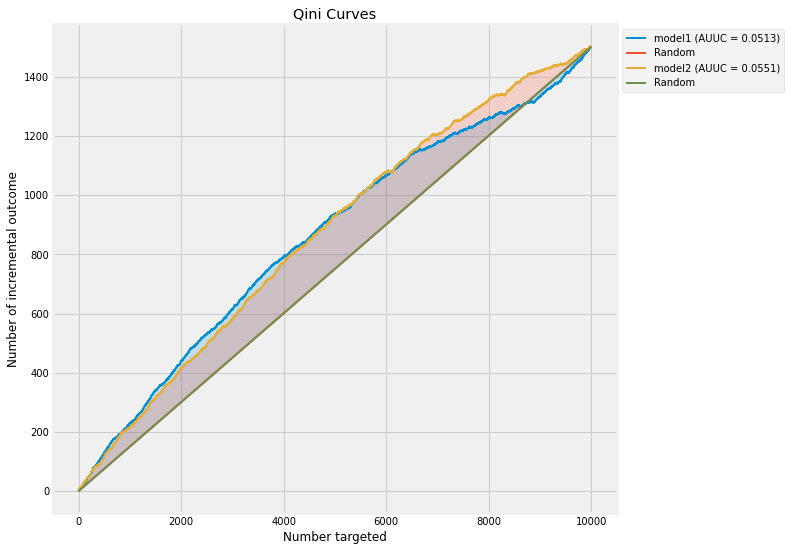

In [156]:
##偏序关系收益验证
fig, ax = plt.subplots(1, 1)
ax.set_title('Qini Curves')
plt.rcParams['lines.linewidth']=2
plt.rcParams['figure.figsize']=(9,9)
plot_qini_curve(X['Y'], X['uplift'], X['sid'], perfect=False, name='model1', ax=ax)
plot_qini_curve(X['Y'], X['uplift2'], X['sid'], perfect=False, name='model2', ax=ax)

In [ ]:
[0.44,0.43,0.39,0.3,0.37,0.29,0.25,0.1,0.18,0.39]

array([<AxesSubplot:title={'center':'Uplift by percentile\nweighted average uplift = 0.3160'}>,
       <AxesSubplot:title={'center':'Response rate by percentile'}, xlabel='Percentile'>],
      dtype=object)

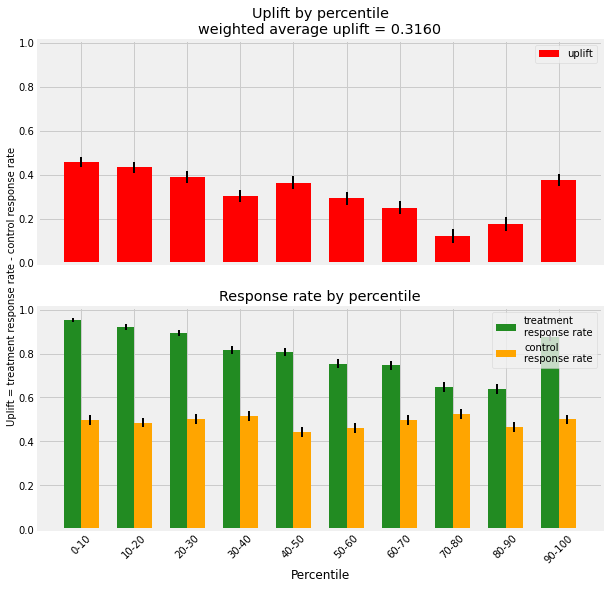

In [135]:
plot_uplift_by_percentile(X['Y'], X['uplift'], X['sid'], \
                          strategy='by_group', kind='bar')

array([<AxesSubplot:title={'center':'Uplift by percentile\nweighted average uplift = 0.3092'}>,
       <AxesSubplot:title={'center':'Response rate by percentile'}, xlabel='Percentile'>],
      dtype=object)

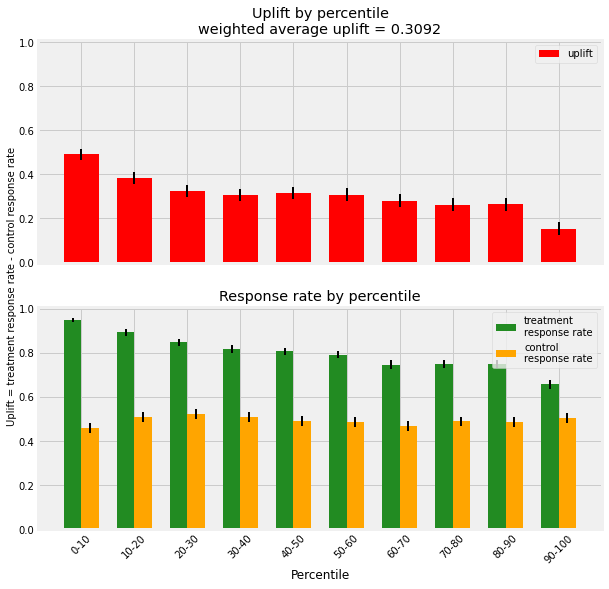

In [113]:
plot_uplift_by_percentile(X['Y'], X['uplift2'], X['sid'], \
                          strategy='by_group', kind='bar')

In [165]:
spearmanr([i for i in range(10,0,-1)],[0.44,0.43,0.39,0.3,0.37,0.29,0.25,0.1,0.18,0.39])

SpearmanrResult(correlation=0.6808542089216724, pvalue=0.03021117068836832)

In [164]:
spearmanr([i for i in range(10,0,-1)],[0.5,0.38,0.35,0.3,0.31,0.29,0.27,0.23,0.24,0.15])

SpearmanrResult(correlation=0.9757575757575757, pvalue=1.4675461874042197e-06)

In [162]:
[i for i in range(10,0,-1)]